In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from geopy.distance import geodesic
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [2]:
# Cargando data

products= pd.read_csv("data/order_products.csv")
orders = pd.read_csv("data/orders.csv")
shoppers = pd.read_csv("data/shoppers.csv")
stores = pd.read_csv("data/storebranch.csv")

# Trabajando data de productos

Transformamdo data de productos en resumen por cada orden, con cantidad de productos distintos por orden, unidades por orden y kilos por orden.


In [3]:
products['kg'] = products.apply(lambda x: x.quantity if x.buy_unit == "KG" else 0, axis = 1) # crea columna con kilos de producto
products['units'] = products.apply(lambda x: x.quantity if x.buy_unit == "UN" else 0, axis = 1) # crea columna con unidades de producto 

order_info = products.groupby('order_id', as_index=False).agg({'product_id':'count', 'kg':'sum', 'units':'sum'})\
            .rename(columns={"product_id":"distinct_q", "kg":"total_kg", "units":"total_units"}) # agrupa totales por orden 

In [4]:
order_info.sort_values(by='distinct_q')

,order_id,distinct_q,total_kg,total_units
5471,8bb0e067cf5302c62ded647d4aef6e5c,1,0.000,4.0
7181,b8e33e8ae603b174956ce684cac4dfee,1,0.000,1.0
7194,b9333a5b7e418675c7fff8b92159da1f,1,0.000,1.0
1833,2fdfbd2ee65811661cc16b276eb33a8a,1,0.000,1.0
7210,b98aa19011d8e051548028a4075c7fb1,1,0.000,1.0
...,...,...,...,...
6515,a77e9b1ac7d19b52b1bbfb4bc08ef158,118,4.736,262.0
9810,fbf351bb22fd781edd54f278bae1668e,120,6.164,191.0
5284,866cdbeb18d0d70414790e6b3962006a,129,12.612,181.0
3471,57c8d0a346f10c0c4fc90739910bea4f,136,2.700,317.0


Vemos que todos los pedidos tienen al menos 1 producto.
No incluyo un Q total de productos porque es seria simplemente la suma de total_kg + total_units lo que es info redundante para el modelo.
En teoria esta información nos ayudará a predecir tiempo porque órdenes con mayor cantidad de productos deberían demorar más, y órdenes con productos con pesaje
también implican tiempo adicional

# Trabajando data de shoppers

In [5]:
shoppers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2864 entries, 0 to 2863
Data columns (total 6 columns):
shopper_id       2864 non-null object
seniority        2864 non-null object
found_rate       2763 non-null float64
picking_speed    2864 non-null float64
accepted_rate    2837 non-null float64
rating           2780 non-null float64
dtypes: float64(4), object(2)
memory usage: 134.4+ KB


En esta data tenemos algunos missing values, 101 sin found rate, 27 sin accepted_rate y 84 sin rating, dado que son un % bajo con respecto al total de la data podríamos eliminarlos. Otra opción es imputar los datos para lo cual veremos las distribuciones.

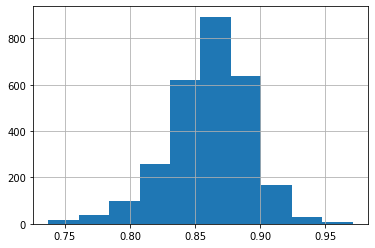

In [6]:
shoppers.found_rate.hist()

El found_rate parece comportarse normal, por lo que imputar un promedio o mediana debería dar resultados parecidos

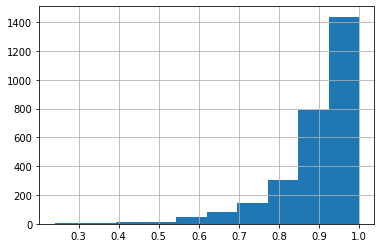

In [7]:
shoppers.accepted_rate.hist()

El accepted_rate tiene una distribución diferente, por lo que creo que imputar un promedio sería malo, en este caso para simplificar también usaré la mediana 

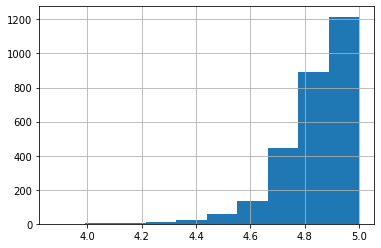

In [8]:
shoppers.rating.hist()

El rating es similar al accepted_rate, por lo que también usaremos la mediana

In [9]:
print('found rate promedio:', shoppers.found_rate.mean(), "mediana:", shoppers.found_rate.median())
print('accept rate promedio:', shoppers.accepted_rate.mean(), "mediana:", shoppers.accepted_rate.median())
print('rating rate promedio:',shoppers.rating.mean(), "mediana:", shoppers.rating.median())

found rate promedio: 0.8610823018458198 mediana: 0.8639
accept rate promedio: 0.9082764196934224 mediana: 0.944444444444444
rating rate promedio: 4.848428057553957 mediana: 4.88


In [10]:
shoppers.found_rate = shoppers.found_rate.fillna(shoppers.found_rate.median())
shoppers.accepted_rate = shoppers.accepted_rate.fillna(shoppers.accepted_rate.median())
shoppers.rating = shoppers.rating.fillna(shoppers.rating.median())

In [11]:
shoppers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2864 entries, 0 to 2863
Data columns (total 6 columns):
shopper_id       2864 non-null object
seniority        2864 non-null object
found_rate       2864 non-null float64
picking_speed    2864 non-null float64
accepted_rate    2864 non-null float64
rating           2864 non-null float64
dtypes: float64(4), object(2)
memory usage: 134.4+ KB


Finalmente el dataframe está imputado y sin valores faltantes

# Uniendo datos y calculando distancias

De la data de tiendas lo que podemos calcular es la distancia entre la tienda y la persona, creo que la opción mas precisa sería calcular la distancia de la ruta segun la api de google maps, pero por temas de tiempo sólo calcularé una distancia de Haversine implemementada en geopy

In [12]:
stores = stores.rename(columns={"lat":"store_lat", "lng":"store_lng"})

In [13]:
data = pd.merge(orders, stores, on='store_branch_id')
data = pd.merge(data, order_info, on='order_id')
data = pd.merge(data, shoppers, on='shopper_id')

In [14]:
# creamos una funcion para calcular la distancia

def get_distance(client_lat, client_lng, store_lat, store_lng):
    """
    get distance in KM between client and store
    """
    start = (client_lat,client_lng)
    end = (store_lat, store_lng)
    return geodesic(start, end).km

data['trip_distance'] = data.apply(lambda x: get_distance(x.lat, x.lng, x.store_lat, x.store_lng), axis=1) # aplicamos la funcion


In [15]:
# borraré columnas que no me parece que aportan información al problema
# podría haber dejado dummies para cada local, pero creo que son demasiadas y terminarían aumentando el r2 sólo por el numero de variables
data_final = data.drop(["order_id", "lat", "lng", "promised_time", "shopper_id", "store_branch_id" , "store_id", "store_lat", "store_lng"], axis=1)

In [16]:
# creando dummies para seniority
data_final = pd.get_dummies(data_final)

# creando metricas con respecto a cantidad de productos y velocidad de picking
# consideré multiplicar este número por el found_rate pero dado que sería una transformación monotónica no cambia la información
data_final['distinct_speed'] = data_final['distinct_q']/data_final['picking_speed']
data_final['unit_speed'] = data_final['total_units']/data_final['picking_speed']
data_final['kg_speed'] = data_final['total_kg']/data_final['picking_speed']

In [17]:
# Separamos las features de la variable a predecir y ademas separamos las que no tienen prediccion.

X = data_final[data_final.total_minutes.notnull()].drop('total_minutes', axis=1)
y = data_final.total_minutes[data_final.total_minutes.notnull()]
X_null = data_final[data_final.total_minutes.isnull()].drop('total_minutes', axis=1)

In [18]:
data_final.corr()

,on_demand,total_minutes,distinct_q,total_kg,total_units,found_rate,picking_speed,accepted_rate,rating,trip_distance,seniority_41dc7c9e385c4d2b6c1f7836973951bf,seniority_50e13ee63f086c2fe84229348bc91b5b,seniority_6c90661e6d2c7579f5ce337c3391dbb9,seniority_bb29b8d0d196b5db5a5350e5e3ae2b1f,distinct_speed,unit_speed,kg_speed
on_demand,1.000000,-0.263293,-0.207620,-0.128286,-0.180227,0.034406,0.062464,-0.032129,-0.006732,0.005634,0.013876,0.050516,-0.059039,0.025824,-0.175299,-0.155671,-0.114918
total_minutes,-0.263293,1.000000,0.585021,0.288973,0.533873,-0.108019,0.080071,-0.020001,-0.020451,0.139457,0.007910,-0.007025,-0.006507,0.029210,0.444660,0.418468,0.229983
distinct_q,-0.207620,0.585021,1.000000,0.500585,0.889299,0.078436,-0.230473,0.110254,-0.030770,0.023058,-0.131345,-0.156152,0.239982,-0.045693,0.931467,0.847566,0.496653
total_kg,-0.128286,0.288973,0.500585,1.000000,0.392071,0.099772,-0.134382,0.074459,-0.016079,0.006954,-0.087771,-0.090565,0.148382,-0.029536,0.475257,0.385614,0.952621
total_units,-0.180227,0.533873,0.889299,0.392071,1.000000,0.077641,-0.194628,0.094332,-0.030248,0.021342,-0.116818,-0.134895,0.208200,-0.032346,0.825856,0.938107,0.392375
found_rate,0.034406,-0.108019,0.078436,0.099772,0.077641,1.000000,-0.378329,0.123773,-0.015806,0.002785,-0.218150,-0.226084,0.354536,-0.005201,0.179623,0.166981,0.153516
picking_speed,0.062464,0.080071,-0.230473,-0.134382,-0.194628,-0.378329,1.000000,-0.280728,0.012385,-0.009541,0.353799,0.420336,-0.642298,0.105520,-0.430061,-0.377149,-0.259791
accepted_rate,-0.032129,-0.020001,0.110254,0.074459,0.094332,0.123773,-0.280728,1.000000,-0.019070,0.007340,0.097764,-0.680666,0.528690,-0.088479,0.173991,0.153980,0.112319
rating,-0.006732,-0.020451,-0.030770,-0.016079,-0.030248,-0.015806,0.012385,-0.019070,1.000000,-0.003499,0.056976,-0.016952,-0.032717,0.023897,-0.030013,-0.026763,-0.014279
trip_distance,0.005634,0.139457,0.023058,0.006954,0.021342,0.002785,-0.009541,0.007340,-0.003499,1.000000,0.001778,-0.005608,-0.000905,0.019797,0.034505,0.032492,0.009936


# Entrenamiento modelos

Primero separamos los dataset en train test con un 80/20 y hacemos shuffle para asegurar que los datos no tengan algún tipo de orden

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=666, shuffle=True)

Entraremos una regresión lineal con valores normalizados

In [20]:
reg = LinearRegression(normalize=True, fit_intercept=True).fit(X_train, y_train)
y_pred = reg.predict(X_test)
y_pred_train = reg.predict(X_train)
print('r2 score', reg.score(X_test, y_test))
print('mae test', mean_absolute_error(y_test, y_pred))
print('mae train', mean_absolute_error(y_train, y_pred_train))
print('mse test', mean_squared_error(y_test, y_pred))
print('mse train', mean_squared_error(y_train, y_pred_train))
errors = y_test - y_pred

r2 score 0.4734525183947802
mae test 18.571542813770726
mae train 19.36828827735535
mse test 585.5167227119338
mse train 654.9631163832267


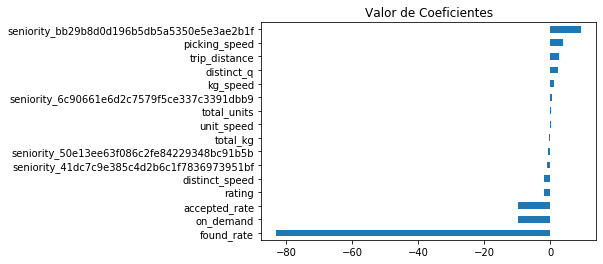

In [21]:
coef_values = pd.Series(reg.coef_, index=X_train.columns).sort_values()
coef_values.plot(kind='barh', title='Valor de Coeficientes')

Los valores de los coeficientes muestran algunas relaciones esperables como un mayor tiempo de despacho a mayor distancia o cantidad de productos. Llaman la atención por ejemplo que picking speed esté relacionado con mayor tiempo de despacho. Quizás el asignador de pedidos manda a los mejores pickers a pedidos mas grandes o que quedan más lejos? Y por eso es que se ve una correlación medio espuria.

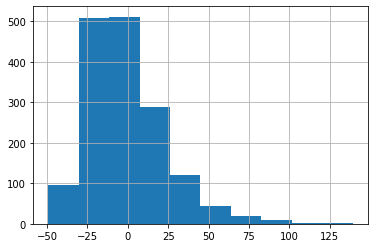

In [22]:
errors.hist()

In [23]:
errors.quantile(.30), errors.quantile(.80)

(-15.099209334812468, 16.517189953389167)

Un 50% de los errores son de entre 15 minutos de adelanto y 15 minutos de retraso, lo que podría llegar a ser tolerable por un cliente (entre percentil 30 y 80)

Este modelo simple logra explicar un 47% de la varianza, y tiene un error promedio parecido entre el dataset de entrenamiento y prueba, lo que nos deja más seguros que no está haciendo overfit. Los errores tienen unos outliers bastante grandes sobre todo para el lado positivo (el tiempo fue muchísimo más del previsto) lo que me hace pensar que son casos muy excepcionales donde quizás el conductor tuvo un accidente, o algo más grave pudo pasar para tener mas de 30 minutos de atraso sobre la predicción (percentil 90 del error). La distribución de los errores si bien no es normal, está casi centrada en 0 y parece mostrar que la regresion lineal logra capturar bastante información para predecir el tiempo de despacho.

También probaré hacer un modelo regularizado, para ver si existe alguna mejoría en comparación a la regresión lineal tradicional

In [24]:
clf = Ridge(alpha=1.0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_pred_train = clf.predict(X_train)
print('r2 score', clf.score(X_test, y_test))
print('mae test', mean_absolute_error(y_test, y_pred))
print('mae train', mean_absolute_error(y_train, y_pred_train))
print('mse test', mean_squared_error(y_test, y_pred))
print('mse train', mean_squared_error(y_train, y_pred_train))

r2 score 0.4741178502407225
mae test 18.56131237550185
mae train 19.36413893501162
mse test 584.7768788506273
mse train 655.1233275447946


Tienen métricas muy similares, por lo que me hace pensar que las variables están bien definidas y que no existen variables que no estén aportando

Probaré un Random Forest para ver si los métodos de árbol logran encontrar patrones no lineales en este dataset, de ser asi deberíamos ver una mejora en la prediccion

In [25]:
regr = RandomForestRegressor(random_state=666)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
y_pred_train = regr.predict(X_train)
print('r2 score', regr.score(X_test, y_test))
print('mae test', mean_absolute_error(y_test, y_pred))
print('mae train', mean_absolute_error(y_train, y_pred_train))
print('mse test', mean_squared_error(y_test, y_pred))
print('mse train', mean_squared_error(y_train, y_pred_train))

r2 score 0.44800654560374675
mae test 19.06986118225547
mae train 7.3252054055345885
mse test 613.8124474382246
mse train 94.63218921977851


Con random forest tenemos un r2 un poco peor que con la regresión lineal, y la diferencia en errores entre train y test es muy grande, por lo que es probable que el árbol esté haciendo overfit a la data de entrenamiento. Por esto limitaremos la profundidad de los arboles. 

In [26]:
regr = RandomForestRegressor(max_depth=8, random_state=666)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
y_pred_train = regr.predict(X_train)
print('r2 score', regr.score(X_test, y_test))
print('mae test', mean_absolute_error(y_test, y_pred))
print('mae train', mean_absolute_error(y_train, y_pred_train))
print('mse test', mean_squared_error(y_test, y_pred))
print('mse train', mean_squared_error(y_train, y_pred_train))

r2 score 0.4677968596755304
mae test 18.6288249374148
mae train 16.637681675344517
mse test 591.805771418381
mse train 460.01582836923666


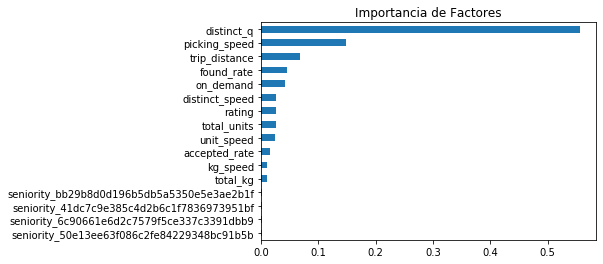

In [27]:
feat_importances = pd.Series(regr.feature_importances_, index=X_train.columns).sort_values()
feat_importances.plot(kind='barh', title='Importancia de Factores')

Limitando la profundidad del árbol corregimos el overfitting del modelo, logrando resultados similares a la regresion lineal.

Podemos ver que las variables mas importantes son la cantidad de productos diferentes, la velocidad del shopper y la distancia del lugar.

### Predicciones finales

Dado que ambos modelos son bastante parecidos, usaré la regresion lineal por su simpleza, ya que me parece la mas eficiente en cuanto a recursos computacionales sin tener que sacrificar eficacia. Por temas de tiempo no pude hacer tuneo de hiperparámetros, pero mi intuición me dice que en este caso no mejoraría mucho para la cantidad de tiempo que podría tomar.

In [28]:
y_null = pd.Series(reg.predict(X_null))

In [29]:
ids = pd.Series(data.order_id[X_null.index]).reset_index(drop=True)

In [30]:
predictions = pd.concat([y_null, ids], axis=1, keys=['total_minutes', 'order_id'])

In [31]:
predictions.to_csv('submission.csv')

### Conclusiones

Si bien el análisis que pude hacer por temas de tiempo fue bastante simple, creo que este problema no requiere de modelos más complejos (ej: deep learning) para poder estimar el tiempo de despacho, sino de más fuentes de datos que no tenemos en este dataset como por ejemplo.

* Información en tiempo real a nivel de local (que tan lleno está, tiempo estimado para pasar por caja, que tanto % de productos fue repuesto, tamaño del súper)
* Información en tiempo real a nivel de ciudad (tráfico, dia feriado, dia laboral, horario peak o no, sector de la ciudad, conectividad con carreteras)
* Información del lugar de entrega (comuna de fácil acceso? , estacionamiento visitas o en la calle?, entrega en la puerta o en conserjeria?)